# Imports

In [1]:
!pip install torchinfo

In [2]:
import collections
import copy
import glob
import io
import itertools
import os
import pathlib
import pickle
import random
import shutil
import time
import warnings
import zipfile
warnings.simplefilter(action="ignore", category=FutureWarning)

import IPython
import IPython.display

import requests

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import PIL

import skimage
import skimage.color
import skimage.io
import skimage.transform

import tqdm.auto as tqdm

import torch
import torch.nn.functional as F

import torchvision

import torchinfo

# Setting random seeds

In [3]:
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

In [4]:
if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") != "" and os.environ.get("KAGGLE_KERNEL_RUN_TYPE") is not None:
    RUNNER = "kaggle"
elif "google.colab" in str(IPython.get_ipython()):
    RUNNER = "colab"
else:
    # assume running on a local machine
    RUNNER = "local"
print(RUNNER)

local


# Determining device

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


# Setting globals

In [6]:
BATCH_SIZE = 8
IMAGE_SIZE = 128
NORMALIZATION_PARAMS = {"mean": (0.485, 0.456, 0.406),
                        "std": (0.229, 0.224, 0.225)}
plt.rcParams["figure.figsize"] = (15, 15)
USE_SMALLER_DATASET = True

# Helper functions and classes

In [7]:
class Denormalize():
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        for t, m ,s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

class StyleTransferDataset(torch.utils.data.Dataset):
    def __init__(self, content_dir, style_dir, transforms=None):
        content_images = glob.glob(content_dir + "/*")
        style_images = glob.glob(style_dir + "/*")
        self.images = list(zip(content_images, style_images))
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        content, style = self.images[idx]
        content_img = skimage.io.imread(content)
        if len(content_img.shape) < 3:
            content_img = skimage.color.gray2rgb(content_img)
        style_img = skimage.io.imread(style)
        if len(style_img.shape) < 3:
            content_img = skimage.color.gray2rgb(content_img)
        content_img = torchvision.transforms.ToTensor()(content_img)
        style_img = torchvision.transforms.ToTensor()(style_img)
        if self.transforms:
            content_img, style_img = self.transforms(content_img), self.transforms(style_img)
        return content_img, style_img

In [8]:
class AdaptiveInstanceNorm2d(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    def _get_mean(self, features):
        batch_size, c = features.size()[:2]
        features_mean = features.reshape(batch_size, c, -1).mean(dim=2).reshape(batch_size, c, 1, 1)
        return features_mean
    
    def _get_std(self, features):
        batch_size, c = features.size()[:2]
        features_std = features.reshape(batch_size, c, -1).std(dim=2).reshape(batch_size, c, 1, 1) + self.eps
        return features_std

    def forward(self, content, style):
        content_mean, content_std = self._get_mean(content), self._get_std(content)
        style_mean, style_std = self._get_mean(style), self._get_std(style)
        normalized = style_std * (content - content_mean) / content_std + style_mean
        return normalized

In [9]:
def download_from_gdrive(id, dest):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params={"id": id}, stream=True)
    token = get_confirm_token(response)
    if token:
        params = {"id": id, "confirm": token}
        response = session.get(URL, params=params, stream=True)

    save_response_content(response, dest)

def get_confirm_token(response):
    for k, v in response.cookies.items():
        if k.startswith("download_warning"):
            return value

    return None

def save_response_content(response, dest):
    with open(dest, "wb") as f:
        for chunk in tqdm.tqdm(response.iter_content(32768), desc="Downloading file", unit="chunks", unit_scale=False):
            if chunk:
                f.write(chunk)

In [10]:
class KMeans:
    def __init__(self, n_clusters, device="cpu", tol=1e-4, init="kmeans++"):
        self.n_clusters = n_clusters
        self.device = device
        self.tol = tol
        self.init = init
        self._labels = None
        self._cluster_centers = None

    def _initial_state(self, data):
        if self.init == "kmeans++":
            n, c = data.shape
            dis = torch.zeros((n, self.n_clusters), device=self.device)
            initial_state = torch.zeros((self.n_clusters, c), device=self.device)
            pr = np.repeat(1 / n, n)
            initial_state[0, :] = data[np.random.choice(np.arange(n), p=pr)]
            dis[:, 0] = torch.sum((data - initial_state[0, :]) ** 2, dim=1)

            for k in range(1, self.n_clusters):
                pr = torch.sum(dis, dim=1) / torch.sum(dis)
                try:
                    initial_state[k, :] = data[np.random.choice(np.arange(n), 1, p=pr.cpu().numpy())]
                except Exception:
                    initial_state[k, :] = data[np.random.choice(np.arange(n), 1, p=np.flatten(np.random.default_rng().dirichlet(np.ones(len(pr)), size=1)))]
                dis[:, k] = torch.sum((data - initial_state[k, :]) ** 2, dim=1)
        else:
            n = data.shape[0]
            indices = np.random.choice(n, self.n_clusters)
            initial_state = data[indices]

        return initial_state

    @staticmethod
    def pairwise_distance(data1, data2=None):
        if data2 is None:
            data2 = data1

        a = data1.unsqueeze(dim=1)
        b = data2.unsqueeze(dim=0)

        dis = (a - b) ** 2.0
        dis = dis.sum(dim=-1).squeeze()
        return dis
    
    def fit(self, data):
        data = data.to(torch.float32)
        cluster_centers = self._initial_state(data)

        while True:
            dis = self.pairwise_distance(data, cluster_centers)
            labels = torch.argmin(dis, dim=1)
            cluster_centers_pre = cluster_centers.clone()

            for index in range(self.n_clusters):
                selected = (labels == index)
                if selected.any():
                    selected = data[labels == index]
                    cluster_centers[index] = selected.mean(dim=0)
                else:
                    cluster_centers[index] = torch.zeros_like(cluster_centers[0], device=self.device)
            
            center_shift = torch.sum(torch.sqrt(torch.sum((cluster_centers - cluster_centers_pre) ** 2, dim=1)))
            if center_shift ** 2 < self.tol:
                break
        
        self._labels = labels
        self._cluster_centers = cluster_centers

    @property
    def labels_(self):
        return self._labels
    
    @property
    def cluster_centers_(self):
        return self._cluster_centers

In [11]:
def fit_epoch(data_train, model, optimizer, criterion, epoch, epochs):
    model.train()
    running_loss = 0.0
    processed_data = 0
    styled = []
    for content, style in tqdm.tqdm(data_train, desc=f"Fitting epoch {epoch + 1}/{epochs}", unit="batch", unit_scale=False):
        try:
            content, style = content.to(DEVICE), style.to(DEVICE)
            optimizer.zero_grad()
            output, output_features, content_features, output_middle, style_middle = model(content, style)
            loss = criterion(output_features, content_features, output_middle, style_middle)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * content.size(0)
            processed_data += content.size(0)
            styled.append(output.detach().cpu())
        finally:
            content, style = content.cpu(), style.cpu()
            del content, style
            torch.cuda.empty_cache()
    train_loss = running_loss / processed_data
    return torch.cat(styled, dim=0), train_loss

def eval_epoch(data_val, model, optimizer, criterion, epoch, epochs):
    model.eval()
    running_loss = 0.0
    processed_data = 0
    styled = []
    for content, style in tqdm.tqdm(data_val, desc=f"Validating epoch {epoch + 1}/{epochs}", unit="batch", unit_scale=False):
        try:
            content, style = content.to(DEVICE), style.to(DEVICE)
            with torch.no_grad():
                output, output_feats, content_feats, output_middle, style_middle = model(content, style)
                loss = criterion(output_feats, content_feats, output_middle, style_middle)
            running_loss += loss.item() * content.size(0)
            processed_data += content.size(0)
            styled.append(output.detach().cpu())
        finally:
            content, style = content.cpu(), style.cpu()
            del content, style
            torch.cuda.empty_cache()
    val_loss = running_loss / processed_data
    return torch.cat(styled, dim=0), val_loss

def train_model(data_train, data_val, model, optimizer, criterion, epochs, start_epoch=0, checkpoint_cooldown=10):
    history = []
    prev_lr = optimizer.param_groups[0]["lr"]
    start_time = time.time()
    with tqdm.tqdm(desc="Epoch", total=epochs, unit="epoch", unit_scale=False) as pbar:
        for epoch in range(epochs):
            try:
                _, train_loss = fit_epoch(data_train, model, optimizer, criterion, epoch, epochs)
                output, val_loss = eval_epoch(data_val, model, optimizer, criterion, epoch, epochs)
                IPython.display.clear_output(wait=True)
                history.append((train_loss, val_loss, optimizer.param_groups[0]["lr"]))
                show_pics_train(data_val, output, history[-1], epoch, 6)
                pbar.update(1)
                pbar.refresh()

                if (epoch + 1) % checkpoint_cooldown == 0:
                    save_model(f"nst_model_{epoch + 1}.tar", mode="training", model=model, optimizer=optimizer, loss=criterion, history=history, epoch=epoch)
            except KeyboardInterrupt as stop:
                tqdm.tqdm.write(f"Training interrupted at epoch {epoch + 1}. Returning history")
                return history
    end_time = time.time()
    train_time = end_time - start_time
    tqdm.tqdm.write(f"Overall training time: {train_time: 0.1f} seconds")
    return history

In [12]:
def show_pics_train(data_val, output, stats, epoch, sample_size):
    log_template = "Styled images on epoch {ep: 03d}.\n\
    Train loss: {t_loss: 0.4f}, validation loss: {v_loss: 0.4f}"
    content, style = next(iter(data_val))
    content = content[:sample_size]
    style = style[:sample_size]
    denorm = Denormalize(mean=NORMALIZATION_PARAMS["mean"], std=NORMALIZATION_PARAMS["std"])
    styled = denorm(output[:sample_size]).permute(0, 2, 3, 1)
    content = denorm(content).permute(0, 2, 3, 1)
    style = denorm(style).permute(0, 2, 3, 1)
    for i in range(sample_size):
        plt.subplot(3, sample_size, i + 1)
        plt.imshow(np.clip(content[i].squeeze().numpy(), 0, 1))
        plt.title("Content")
        plt.axis("off")

        plt.subplot(3, sample_size, i + 1 + sample_size)
        plt.imshow(np.clip(style[i].squeeze().numpy(), 0, 1))
        plt.title("Style")
        plt.axis("off")

        plt.subplot(3, sample_size, i + 1 + 2 * sample_size)
        plt.imshow(np.clip(styled[i].squeeze().numpy(), 0, 1))
        plt.title("Styled")
        plt.axis("off")
    plt.suptitle(log_template.format(ep=epoch + 1, t_loss=stats[0], v_loss=stats[1]))
    plt.show()

def plot_pics(pics, sample_size=6):
    for i in range(sample_size):
        plt.subplot(2, sample_size // 2 + 1, i + 1)
        image = pics[i]
        image = image.permute(1, 2, 0)
        plt.imshow(image.squeeze().numpy())
        plt.title("Images")
        plt.axis("off")
    plt.show()

def plot_loss(history):
    train_loss, val_loss, _ = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(train_loss, label="Train loss")
    plt.plot(val_loss, label="Validation loss")
    plt.legend(loc="best")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

def plot_learn_rate(history):
    _, _, learn_rate = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(learn_rate, label="Learn rate")
    plt.legend(loc="best")
    plt.xlabel("Epochs")
    plt.ylabel("Learn rate")
    plt.show()

In [13]:
def style_transfer(model, content, style):
    model.eval()
    try:
        content, style = content.to(DEVICE), style.to(DEVICE)
        if content.dim() != 4:
            content = content.unsqueeze(0)
        if style.dim() != 4:
            style = style.unsqueeze(0)
        with torch.no_grad():
            styled = model.generate(content, style)
        styled = styled.detach().cpu()
    finally:
        content, style = content.cpu(), style.cpu()
        del content, style
        torch.cuda.empty_cache()
    return styled

In [14]:
def save_model(path, model, mode="inference", **kwargs):
    if mode == "training":
        torch.save({
            "epoch": kwargs["epoch"],
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": kwargs["optimizer"].state_dict(),
            "loss": kwargs["loss"],
            "history": kwargs["history"]},
            path)
    elif mode == "torchscript":
        torch.jit.script(model).save(path)
    else:
        torch.save(model, path)

def load_model(path, model_arch=None, mode="inference", optim_class=None, optim_kwargs=None):
    if mode == "training":
        if not optim_class:
            raise ValueError("Optimizer class required to load a model saved for training.")
        if not model_arch:
            raise ValueError("Model architecture required to load a model saved for training.")
        model = model_arch()
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint["model_state_dict"])
        if not optim_kwargs:
            optim = optim_class(model.parameters())
        else:
            optim = optim_class(model.parameters(), **optim_kwargs)
        optim.load_state_dict(checkpoint["optim_state_dict"])
        epoch = checkpoint["epoch"]
        loss = checkpoint["loss"]
        history = checkpoint["history"]
        model.eval()
        return model, optim, epoch, loss, history
    elif mode == "torchscript":
        model = torch.jit.load(path)
        model.eval()
        return model
    else:
        model = torch.load(path)
        model.eval()
        return model

def save_history(path, history):
    with open(path, "wb") as f:
        pickle.dump(history, f)

def load_history(path):
    with open(path, "rb") as f:
        history = pickle.load(f)
        
    return history

# Downloading data

There are different ways to download required data depending on runner type, and different requirements for those to work.

If you are:
* Running the notebook in a Kaggle session: add the `shaorrran/coco-wikiart-nst-dataset-512-100000` dataset to the session.
* Running the notebook in Google Colab: upload your `kaggle.json` file into the session.
* Running the notebook locally: have Kaggle API installed and your token ready.

In [15]:
DATASET_NAME = "shaorrran/cocowikiart-nst-dataset-small" if USE_SMALLER_DATASET \
else "shaorrran/coco-wikiart-nst-dataset-512-100000"
if RUNNER == "kaggle":
    name = DATASET_NAME.split("/")[1]
    DATASET_PATH = f"/kaggle/input/{name}"
elif RUNNER == "colab":
    from google.colab import files
    files.upload()
    os.makedirs("/root/.kaggle", exist_ok=True)
    !mv kaggle.json /root/.kaggle/kaggle.json
    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle datasets download -d {DATASET_NAME} --unzip
    DATASET_PATH = os.getcwd()
else:
    if not (os.path.exists("content.zip") and os.exists("style.zip")) \
    and not (os.path.isdir("content") and os.path.isdir("style")):
        !kaggle datasets download -d {DATASET_NAME} --unzip
    else:
        if os.path.exists("content.zip"):
            with zipfile.ZipFile("content.zip", "r") as archive:
                for member in tqdm.tqdm(archive.namelist(), desc="Extracting", unit="files", unit_scale=False):
                    archive.extract(member, os.getcwd())
            !rm content.zip
        if os.path.exists("style.zip"):
            with zipfile.ZipFile("style.zip", "r") as archive:
                for member in tqdm.tqdm(archive.namelist(), desc="Extracting", unit="files", unit_scale=False):
                    archive.extract(member, os.getcwd())
            !rm style.zip
        if not (os.path.isdir("content") and os.path.isdir("style")):
                raise ValueError("Dataset not found.")
    DATASET_PATH = os.getcwd()

# Creating Dataset and Dataloaders

In [16]:
data = StyleTransferDataset(os.path.join(DATASET_PATH, "content"), os.path.join(DATASET_PATH, "style"))
data_train, data_val = torch.utils.data.random_split(data, 
                                                     [int(0.95 * len(data)), len(data) - int(0.95 * len(data))], 
                                                     generator=torch.Generator().manual_seed(RANDOM_STATE))
train_loader = torch.utils.data.DataLoader(data_train, batch_size=int(BATCH_SIZE), shuffle=True, 
                                           num_workers=torch.multiprocessing.cpu_count(), 
                                           pin_memory=True, 
                                           drop_last=True)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=int(BATCH_SIZE), shuffle=False, 
                                           num_workers=torch.multiprocessing.cpu_count(), 
                                           pin_memory=True, 
                                           drop_last=True)

# Defining models

In [17]:
class NormalizedVGG(torch.nn.Module):
    def __init__(self, pretrained_path=None):
        super().__init__()
        self.tail = torch.nn.Sequential(collections.OrderedDict([
            ("conv_initial", torch.nn.Conv2d(3, 3, kernel_size=1)),
            ("reflectpad_tail", torch.nn.ReflectionPad2d((1, 1, 1, 1))),
            ("conv_tail", torch.nn.Conv2d(3, 64, kernel_size=3)),
            ("act_tail", torch.nn.ReLU(inplace=True))
        ]))
        self.lower_spine = torch.nn.Sequential(collections.OrderedDict([
            ("reflectpad_lspine0", torch.nn.ReflectionPad2d((1, 1, 1, 1))),
            ("conv_lspine0", torch.nn.Conv2d(64, 64, kernel_size=3)),
            ("act_lspine0", torch.nn.ReLU(inplace=True)),
            ("maxpool_lspine", torch.nn.MaxPool2d(2, ceil_mode=True)),
            ("reflectpad_lspine1", torch.nn.ReflectionPad2d((1, 1, 1, 1))),
            ("conv_lspine1", torch.nn.Conv2d(64, 128, kernel_size=3)),
            ("act_lspine1", torch.nn.ReLU(inplace=True))
        ]))
        self.spine = torch.nn.Sequential(collections.OrderedDict([
            ("reflectpad_spine0", torch.nn.ReflectionPad2d((1, 1, 1, 1))),
            ("conv_spine0", torch.nn.Conv2d(128, 128, kernel_size=3)),
            ("act_spine0", torch.nn.ReLU(inplace=True)),
            ("maxpool_spine", torch.nn.MaxPool2d(2, ceil_mode=True)),
            ("reflectpad_spine1", torch.nn.ReflectionPad2d((1, 1, 1, 1))),
            ("conv_spine1", torch.nn.Conv2d(128, 256, kernel_size=3)),
            ("act_spine1", torch.nn.ReLU(inplace=True))
        ]))
        self.neck = torch.nn.Sequential(collections.OrderedDict([
            ("reflectpad_neck0", torch.nn.ReflectionPad2d((1, 1, 1, 1))),
            ("conv_neck0", torch.nn.Conv2d(256, 256, kernel_size=3)),
            ("act_neck0", torch.nn.ReLU(inplace=True)),
            ("reflectpad_neck1", torch.nn.ReflectionPad2d((1, 1, 1, 1))),
            ("conv_neck1", torch.nn.Conv2d(256, 256, kernel_size=3)),
            ("act_neck1", torch.nn.ReLU(inplace=True)),
            ("reflectpad_neck2", torch.nn.ReflectionPad2d((1, 1, 1, 1))),
            ("conv_neck2", torch.nn.Conv2d(256, 256, kernel_size=3)),
            ("act_neck2", torch.nn.ReLU(inplace=True)),
            ("maxpool_neck", torch.nn.MaxPool2d(2, ceil_mode=True)),
            ("reflectpad_neck3", torch.nn.ReflectionPad2d((1, 1, 1, 1))),
            ("conv_neck3", torch.nn.Conv2d(256, 512, kernel_size=3)),
            ("act_neck3", torch.nn.ReLU(inplace=True))
        ]))
        self.head = torch.nn.Sequential(collections.OrderedDict([    
            ("reflectpad_head0", torch.nn.ReflectionPad2d((1, 1, 1, 1))),
            ("conv_head0", torch.nn.Conv2d(512, 512, kernel_size=3)),
            ("act_head0", torch.nn.ReLU(inplace=True)),
            ("reflectpad_head1", torch.nn.ReflectionPad2d((1, 1, 1, 1))),
            ("conv_head1", torch.nn.Conv2d(512, 512, kernel_size=3)),
            ("act_head1", torch.nn.ReLU(inplace=True)),
            ("reflectpad_head2", torch.nn.ReflectionPad2d((1, 1, 1, 1))),
            ("conv_head2", torch.nn.Conv2d(512, 512, kernel_size=3)),
            ("act_head2", torch.nn.ReLU(inplace=True)),
            ("maxpool_head", torch.nn.MaxPool2d(2, ceil_mode=True)),
            ("reflectpad_head3", torch.nn.ReflectionPad2d((1, 1, 1, 1))),
            ("conv_head3", torch.nn.Conv2d(512, 512, kernel_size=3)),
            ("act_head3", torch.nn.ReLU(inplace=True))
        ]))
        if pretrained_path is not None:
            self._load_weights(torch.load(pretrained_path, map_location=lambda storage, loc: storage))

        for p in self.parameters():
            p.requires_grad = False
    
    def _load_weights(self, state_dict):
        self_dict = self.state_dict()
        self_dict = {k: v for k, v in zip(self_dict.keys(), state_dict.values())}
        self.load_state_dict(self_dict)
        
    def forward(self, x, target="head", output_last_feature=True):
        x_tail = self.tail(x)
        x_lower_spine = self.lower_spine(x_tail)
        x_spine = self.spine(x_lower_spine)
        x_neck = self.neck(x_spine)
        x_head = self.head(x_neck)
        if output_last_feature:
            if target == "tail":
                return x_tail
            if target == "lower_spine":
                return x_lower_spine
            if target == "spine":
                return x_spine
            if target == "neck":
                return x_neck
            return x_head
        else:
            if target == "tail":
                return x_tail
            if target == "lower_spine":
                return x_tail, x_lower_spine
            if target == "spine":
                return x_tail, x_lower_spine, x_spine
            if target == "neck":
                return x_tail, x_lower_spine, x_spine, x_neck
            return x_tail, x_lower_spine, x_spine, x_neck, x_head

class Decoder(torch.nn.Module):
    def __init__(self, level, pretrained_path=None):
        super().__init__()
        decoder_layers = collections.OrderedDict([
            ("reflectpad0", torch.nn.ReflectionPad2d((1, 1, 1, 1))),
            ("conv0", torch.nn.Conv2d(512, 512, kernel_size=3)),
            ("act0", torch.nn.ReLU(inplace=True)),
            ("upsample0", torch.nn.Upsample(scale_factor=2)),
            ("reflectpad1", torch.nn.ReflectionPad2d((1, 1, 1, 1))),
            ("conv1", torch.nn.Conv2d(512, 512, kernel_size=3)),
            ("act1", torch.nn.ReLU(inplace=True)),
            ("reflectpad2", torch.nn.ReflectionPad2d((1, 1, 1, 1))),
            ("conv2", torch.nn.Conv2d(512, 512, kernel_size=3)),
            ("act2", torch.nn.ReLU(inplace=True)),
            ("reflectpad3", torch.nn.ReflectionPad2d((1, 1, 1, 1))),
            ("conv3", torch.nn.Conv2d(512, 512, kernel_size=3)),
            ("act3", torch.nn.ReLU(inplace=True)),
            ("reflectpad4", torch.nn.ReflectionPad2d((1, 1, 1, 1))),
            ("conv4", torch.nn.Conv2d(512, 256, kernel_size=3)),
            ("act4", torch.nn.ReLU(inplace=True)),
            ("upsample1", torch.nn.Upsample(scale_factor=2)),
            ("reflectpad5", torch.nn.ReflectionPad2d((1, 1, 1, 1))),
            ("conv5", torch.nn.Conv2d(256, 256, kernel_size=3)),
            ("act5", torch.nn.ReLU(inplace=True)),
            ("reflectpad6", torch.nn.ReflectionPad2d((1, 1, 1, 1))),
            ("conv6", torch.nn.Conv2d(256, 256, kernel_size=3)),
            ("act6", torch.nn.ReLU(inplace=True)),
            ("reflectpad7", torch.nn.ReflectionPad2d((1, 1, 1, 1))),
            ("conv7", torch.nn.Conv2d(256, 256, kernel_size=3)),
            ("act7", torch.nn.ReLU(inplace=True)),
            ("reflectpad8", torch.nn.ReflectionPad2d((1, 1, 1, 1))),
            ("conv8", torch.nn.Conv2d(256, 128, kernel_size=3)),
            ("act8", torch.nn.ReLU(inplace=True)),
            ("upsample2", torch.nn.Upsample(scale_factor=2)),
            ("reflectpad9", torch.nn.ReflectionPad2d((1, 1, 1, 1))),
            ("conv9", torch.nn.Conv2d(128, 128, kernel_size=3)),
            ("act9", torch.nn.ReLU(inplace=True)),
            ("reflectpad10", torch.nn.ReflectionPad2d((1, 1, 1, 1))),
            ("conv10", torch.nn.Conv2d(128, 64, kernel_size=3)),
            ("act10", torch.nn.ReLU(inplace=True)),
            ("upsample3", torch.nn.Upsample(scale_factor=2)),
            ("reflectpad11", torch.nn.ReflectionPad2d((1, 1, 1, 1))),
            ("conv11", torch.nn.Conv2d(64, 64, kernel_size=3)),
            ("act11", torch.nn.ReLU(inplace=True)),
            ("reflectpad12", torch.nn.ReflectionPad2d((1, 1, 1, 1))),
            ("conv12", torch.nn.Conv2d(64, 3, kernel_size=3))
        ])
        if level == 1:
            self.layers = torch.nn.Sequential(collections.OrderedDict(list(decoder_layers.items())[-2:]))
        elif level == 2:
            self.layers = torch.nn.Sequential(collections.OrderedDict(list(decoder_layers.items())[-9:]))
        elif level == 3:
            self.layers = torch.nn.Sequential(collections.OrderedDict(list(decoder_layers.items())[-16:]))
        elif level == 4:
            self.layers = torch.nn.Sequential(collections.OrderedDict(list(decoder_layers.items())[-29:]))
        elif level == 5:
            self.layer = torch.nn.Sequential(decoder_layers)
        else:
            raise ValueError("level should be between 1 and 5")
        if pretrained_path is not None:
            self._load_weights(torch.load(pretrained_path, map_location=lambda storage, loc: storage))
            
    def _load_weights(self, state_dict):
        self_dict = self.state_dict()
        self_dict = {k: v for k, v in zip(self_dict.keys(), state_dict.values())}
        self.load_state_dict(self_dict)

    def forward(self, x):
        return self.layers(x)

class StyleTransferCNN(torch.nn.Module):
    def __init__(self, alpha=1, pretrained=False):
        super().__init__()
        self.alpha = alpha
        torchhub_save_dir = (pathlib.Path.home() / ".cache" / "torch" / "hub" / "checkpoints")
        torchhub_save_dir.mkdir(parents=True, exist_ok=True)
        if not (torchhub_save_dir / "vgg_normalized_conv5_1.pth").is_file():
                download_from_gdrive("1IAOFF5rDkVei035228Qp35hcTnliyMol", torchhub_save_dir / "vgg_normalized_conv5_1.pth")
        self.encoder = NormalizedVGG(pretrained_path=(torchhub_save_dir / "vgg_normalized_conv5_1.pth"))
        if pretrained:
            if not (torchhub_save_dir / "decoder_relu4_1.pth").is_file():
                download_from_gdrive("1kkoyNwRup9y5GT1mPbsZ_7WPQO9qB7ZZ", torchhub_save_dir / "decoder_relu4_1.pth")
            self.decoder = Decoder(level=4, pretrained_path=torchhub_save_dir / "decoder_relu4_1.pth")
        else:
            self.decoder = Decoder(level=4)
    
    def _apply(self, fn):
        # redefine to move encoder and decoder to the same device the main model is on
        super()._apply(fn)
        self.encoder._apply(fn)
        self.decoder._apply(fn)
        return self

    def _calc_k(self, x, max_cluster=5, threshold_min=0.1, threshold_max=0.7):
        image = torchvision.transforms.ToPILImage()(x).convert("RGB")
        w, h = image.size
        w, h = self._calc_maxpool_size(w, h, 3)
        image = image.resize((w, h))
        image = skimage.color.rgb2lab(image).reshape(w * h, -1)
        k = 2
        k_means = KMeans(k, device=x.device)
        image = torch.from_numpy(image).to(k_means.device)
        k_means.fit(image)
        labels = k_means.labels_
        prev_labels = k_means.labels_
        prev_cluster_centers = k_means.cluster_centers_
        while True:
            cnt = collections.Counter(labels.cpu().tolist())
            if k <= max_cluster and (cnt.most_common()[-1][1] / (w * h) > threshold_min or cnt.most_common()[0][1] / (
                w * h) > threshold_max):
                if cnt.most_common()[-2][1] / (w * h) < threshold_min:
                    labels = prev_labels
                    cluster_centers = prev_cluster_centers
                    k -= 1
                    break
                k += 1
            else:
                if k > max_cluster:
                    labels = prev_labels
                    cluster_centers = prev_cluster_centers
                    k -= 1
                else:
                    labels = k_means.labels_
                    cluster_centers = k_means.cluster_centers_
                break

            prev_labels = k_means.labels_
            prev_cluster_centers = k_means.cluster_centers_

            k_means = KMeans(k, device=x.device)
            k_means.fit(image)
            labels = k_means.labels_
        
        new_clusters = cluster_centers.norm(dim=1).argsort(descending=False).tolist()
        new_clusters = [new_clusters.index(j) for j in range(k)]
        cluster_centers_norm, _ = torch.sort(cluster_centers.norm(dim=1))
        cluster_centers_norm -= cluster_centers_norm.min()
        cluster_centers_norm /= cluster_centers_norm.max()

        new_labels = torch.zeros_like(labels)
        for i in range(k):
            new_labels[labels == i] = new_clusters[i]
        
        label = new_labels.reshape(h, w)

        return label, cluster_centers_norm

    def _calc_maxpool_size(self, w, h, count=3):
        if count == 3:
            w = np.ceil(np.ceil(np.ceil(w / 2) / 2) / 2)
            h = np.ceil(np.ceil(np.ceil(h / 2) / 2) / 2)
        elif count == 2:
            w = np.ceil(np.ceil(w / 2) / 2)
            h = np.ceil(np.ceil(h / 2) / 2)
        elif count == 1:
            w = np.ceil(w / 2)
            h = np.ceil(h / 2)
        else:
            raise ValueError
        return int(w), int(h)

    def _cluster_matching(self, content_label, style_label, content_cluster_center_norm, style_cluster_center_norm, threshold=0.25):
        content_k = int(content_label.max().item() + 1)
        style_k = int(style_label.max().item() + 1)
        res = {}
        for i in range(content_k):
            res[i] = []
            match = False
            for j in range(style_k):
                if torch.abs(content_cluster_center_norm[i] - style_cluster_center_norm[j]) <= threshold:
                    match = True
                    res[i].append(j)
            if not match:
                res[i] = [jj for jj in range(style_k)]
        
        return res

    def _labeled_whiten_and_color(self, f_c, f_s, alpha, clabel):
        try:
            cc, ch, cw = f_c.shape
            cf = (f_c * clabel).reshape(cc, -1)
            num_nonzero = torch.sum(clabel).item() / cc
            c_mean = (torch.sum(cf, 1) / num_nonzero).reshape(cc, 1, 1) * clabel
            cf = (cf.reshape(cc, ch, cw) - c_mean).reshape(cc, -1)
            
            c_cov = torch.mm(cf, ct.t()) / (num_nonzero - 1)
            c_u, c_e, c_v = torch.svd(c_cov)
            c_d = c_e.pow(-0.5)

            w_step1 = torch.mm(c_v, torch.diag(c_d))
            w_step2 = torch.mm(w_step1, (c_v.t()))
            whitened = torch.mm(w_step2, cf)

            sf = f_s
            sc, shw = sf.shape
            s_mean = torch.mean(f_s, 1, keepdim=True)
            sf -= s_mean

            s_cov = torch.mm(sf, sf.t()) / (shw - 1)
            s_u, s_e, s_v = torch.svd(s_cov)
            s_d = s_e.pow(-0.5)

            c_step1 = torch.mm(s_v, torch.diag(s_d))
            c_step2 = torch.mm(c_step1, s_v.t())
            colored = torch.mm(c_step2, whitened).reshape(cc, ch, cw)

            colored += s_mean.reshape(sc, 1, 1) * clabel
            colored_feature = alpha * colored + (1 - alpha) * (f_c * clabel)
        except:
            colored_feature = f_c * clabel
        
        return colored_feature

    def generate(self, content, style):
        cs = []
        content_features = self.encoder(content, target="neck")
        style_features = self.encoder(style, target="neck")

        for c_image, s_image, c_feat, s_feat in zip(content, style, content_features, style_features):
            content_label, content_center_norm = self._calc_k(c_image)
            style_label, style_center_norm = self._calc_k(s_image)
            match = self._cluster_matching(content_label, style_label, content_center_norm, style_center_norm)

            cs_feature = torch.zeros_like(c_feat)
            for i, j in match.items():
                cl = (content_label == i).unsqueeze(dim=0).expand_as(c_feat).to(torch.float)
                sl = torch.zeros_like(s_feat)
                for jj in j:
                    sl += (style_label == jj).unsqueeze(dim=0).expand_as(s_feat).to(torch.float)
                sl = sl.to(torch.bool)
                sub_sf = s_feat[sl].reshape(s_feat.shape[0], -1)
                cs_feature += self._labeled_whiten_and_color(c_feat, sub_sf, self.alpha, cl)

            cs.append(cs_feature.unsqueeze(dim=0))
        cs = torch.cat(cs, dim=0)
        out = self.decoder(cs)
        return out

    def forward(self, content, style):
        out = self.generate(content, style)
        content_features = self.encoder(content)
        out_features = self.encoder(out, output_last_feature=True)
        out_middle_features = self.encoder(out, output_last_feature=False)
        style_middle_features = self.encoder(style, output_last_feature=False)
        return out, content_features, out_features, out_middle_features, style_middle_features

In [18]:
model = StyleTransferCNN().to(DEVICE)

In [19]:
torchinfo.summary(model, ((int(BATCH_SIZE), 3, IMAGE_SIZE, IMAGE_SIZE), (int(BATCH_SIZE), 3, IMAGE_SIZE, IMAGE_SIZE)))

Layer (type:depth-idx)                   Output Shape              Param #
StyleTransferCNN                         --                        --
├─NormalizedVGG: 1-1                     [8, 512, 16, 16]          --
│    └─Sequential: 2-1                   [8, 64, 128, 128]         --
│    │    └─Conv2d: 3-1                  [8, 3, 128, 128]          (12)
│    │    └─ReflectionPad2d: 3-2         [8, 3, 130, 130]          --
│    │    └─Conv2d: 3-3                  [8, 64, 128, 128]         (1,792)
│    │    └─ReLU: 3-4                    [8, 64, 128, 128]         --
│    └─Sequential: 2-2                   [8, 128, 64, 64]          --
│    │    └─ReflectionPad2d: 3-5         [8, 64, 130, 130]         --
│    │    └─Conv2d: 3-6                  [8, 64, 128, 128]         (36,928)
│    │    └─ReLU: 3-7                    [8, 64, 128, 128]         --
│    │    └─MaxPool2d: 3-8               [8, 64, 64, 64]           --
│    │    └─ReflectionPad2d: 3-9         [8, 64, 66, 66]           --
│ 

In [20]:
!nvidia-smi

Sun Feb 13 05:53:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   71C    P0    N/A /  N/A |    957MiB /  3020MiB |     36%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Defining loss

In [21]:
class StyleTransferLoss(torch.nn.Module):
    def __init__(self, lam=10):
        super().__init__()
        self.lam = lam

    def _style_loss(self, content_middle, style_middle):
        loss = 0
        inst_norm = AdaptiveInstanceNorm2d()
        for c, s in zip(content_middle, style_middle):
            c_mean, c_std = inst_norm._get_mean(c), inst_norm._get_std(c)
            s_mean, s_std = inst_norm._get_mean(s), inst_norm._get_std(s)
            loss += F.mse_loss(c_mean, s_mean) + F.mse_loss(c_std, s_std)
        return loss

    def _content_loss(self, output_feats, content_feats):
        return F.mse_loss(output_feats, content_feats)

    def forward(self, output_feats, content_feats, output_middle, style_middle):
        return self._content_loss(output_feats, content_feats) + self.lam * self._style_loss(output_middle, style_middle)

# Training model

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = StyleTransferLoss()

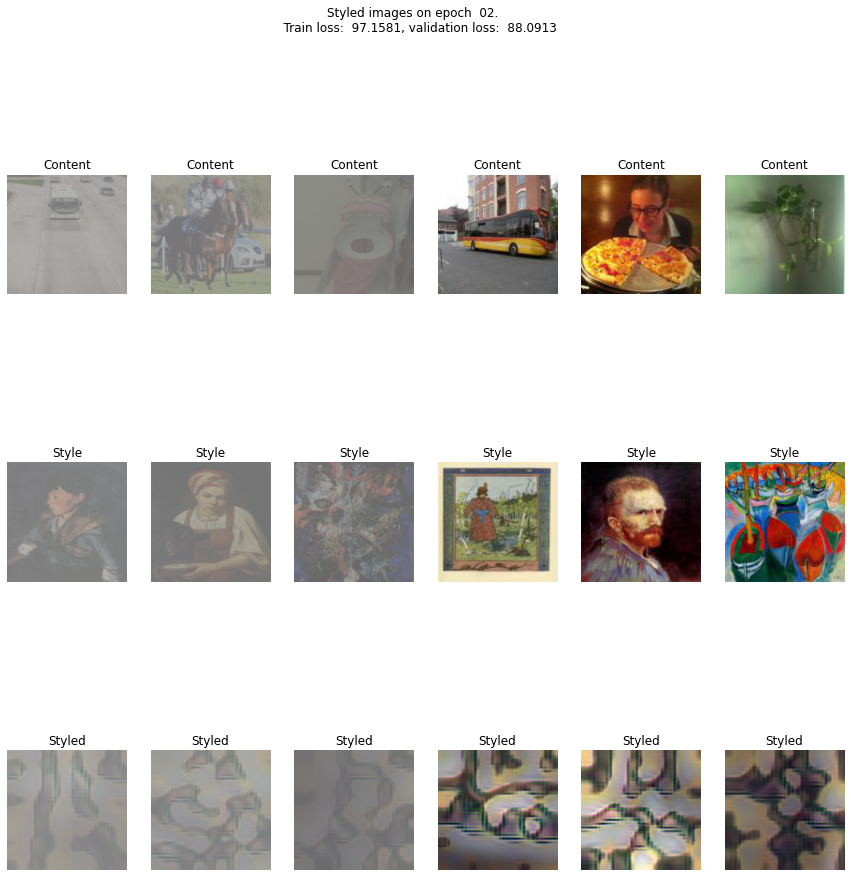

Fitting epoch 3/25:   0%|          | 0/593 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f84939f4ca0>
Traceback (most recent call last):
  File "/home/shaorrran/.virtualenvs/dls/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/shaorrran/.virtualenvs/dls/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/shaorrran/.pyenv/versions/3.8.9/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f84939f4ca0>
Traceback (most recent call last):
  File "/home/shaorrran/.virtualenvs/dls/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/shaorrran/.virtualenvs/dls/lib/python3.8/s

Validating epoch 3/25:   0%|          | 0/31 [00:00<?, ?batch/s]

In [ ]:
max_epochs = 25
history_nst = train_model(train_loader, val_loader, model, optimizer, criterion, max_epochs)

In [ ]:
plot_loss(history_nst)

# Validating model

In [ ]:
test_content, test_style = next(iter(val_loader))
test_styled = style_transfer(model, test_content, test_style)
plot_pics(Denormalize(mean=NORMALIZATION_PARAMS["mean"], std=NORMALIZATION_PARAMS["std"])(test_styled))

# Saving model

In [ ]:
save_model("nst_vgg_semst.pth", model, mode="inference")

In [ ]:
try:
    save_model(f"nst_vgg_semst_torchscript.pth", model, mode="torchscript")
except Exception: # not sure which one torch.jit.script will throw if an operation is unscriptable
    pass

# Reinitialize model with pretrained weights and save as a reference

In [ ]:
# let's clear out the previous one first
model = model.cpu()
del model
torch.cuda.empty_cache()

In [ ]:
model = StyleTransferCNN(pretrained=True).to(DEVICE)

In [ ]:
# Check out the outputs
test_content, test_style = next(iter(val_loader))
test_styled = style_transfer(model, test_content, test_style)
plot_pics(Denormalize(mean=NORMALIZATION_PARAMS["mean"], std=NORMALIZATION_PARAMS["std"])(test_styled))

In [ ]:
save_model("nst_vgg_semst_pretrained.pth", model, mode="inference")

In [ ]:
try:
    save_model(f"nst_vgg_semst_pretrained_torchscript.pth", mode="torchscript")
except Exception: # not sure which one torch.jit.script will throw if an operation is unscriptable
    pass